### Probabilistic Graphical Model - Inpainting Experiment with CVAE
**Author:** Felipe Cortes Jaramillo

**Description:** We want to do in-painting with the data from the "MLDM-Project".

**References:** The following code was inspired in the tutorial: https://www.tensorflow.org/tutorials/generative/cvae

### Libraries and Data Pre-processing:

In [1]:
# First, we install libraries needed
#!pip install tensorflow-probability neurite

In [2]:
import tensorflow as tf
#import tensorflow_probability as tfp
import glob
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import time

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Check if TensorFlow is able to detect the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only one GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print("RuntimeError:", e)
else:
    raise SystemError("GPU device not found")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# We mount Colab for this
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Let's load the data (Based on a cut)
images_route_24_30 = f'./../../data/size_480/24_30/'
images_route_22_30 = f'./../../data/size_480/22_30/'
images_route_20_2  = f'./../../data/size_480/20_2/'
#images_route_24_30 = f'./drive/MyDrive/data/size_480/24_30/'
#images_route_22_30 = f'./drive/MyDrive/data/size_480/22_30/'
#images_route_20_2  = f'./drive/MyDrive/data/size_480/20_2/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
#filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
#filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
#data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
#data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
#print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
#print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (572, 480, 480)


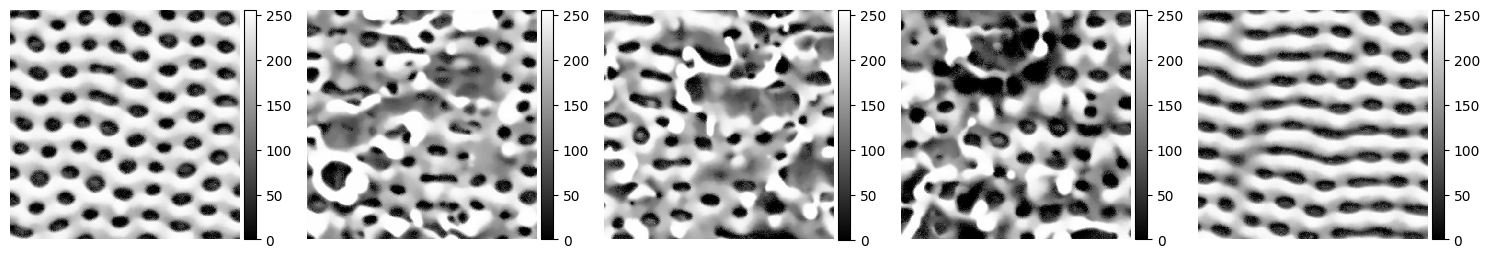

In [6]:
# We can visualize some of the data from the first set (trajectory 24_30)
nb_vis = 5
# Choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]
# Plot some examples
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [7]:
# Basic normalization step to be in range [0 - 1]

x_24_30 = np.expand_dims(data_set_24_30.astype('float32')/255, -1)
#x_22_30 = np.expand_dims(data_set_22_30.astype('float32')/255, -1)
#x_20_2  = np.expand_dims(data_set_20_2.astype('float32')/255, -1)

# Verify
print('Set of 24_30 maximum value', x_24_30.max())
#print('Set of 22_30 maximum value', x_22_30.max())
#print('Set of 20_2 maximum value', x_20_2.max())

Set of 24_30 maximum value 1.0


In [8]:
# Finally, we define the train, val and test set for each trajectory

X_train_24_30, X_test_24_30 = train_test_split(x_24_30, test_size=0.1, random_state=42)
X_test_24_30, X_eval_24_30 = train_test_split(X_test_24_30, test_size=0.5, random_state=42)

#X_train_22_30, X_test_22_30 = train_test_split(x_22_30, test_size=0.1, random_state=42)
#X_test_22_30, X_eval_22_30 = train_test_split(X_test_22_30, test_size=0.5, random_state=42)

#X_train_20_2, X_test_20_2 = train_test_split(x_20_2, test_size=0.1, random_state=42)
#X_test_20_2, X_eval_20_2 = train_test_split(X_test_20_2, test_size=0.5, random_state=42)

print('< -------- // -------- >')
print(f'Shape of 24_30 training data: {X_train_24_30.shape}, eval data: {X_eval_24_30.shape}, and test data: {X_test_24_30.shape}')
#print(f'Shape of 22_30 training data: {X_train_22_30.shape}, eval data: {X_eval_22_30.shape}, and test data: {X_test_22_30.shape}')
#print(f'Shape of 20_2 training data: {X_train_20_2.shape}, eval data: {X_eval_20_2.shape}, and test data: {X_test_20_2.shape}')

< -------- // -------- >
Shape of 24_30 training data: (514, 480, 480, 1), eval data: (29, 480, 480, 1), and test data: (29, 480, 480, 1)


In [9]:
# Trajectory (24_30 in this case):
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train_24_30)
                 .shuffle(500).batch(5))
eval_dataset = (tf.data.Dataset.from_tensor_slices(X_eval_24_30)
                .shuffle(500).batch(5))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test_24_30)
                .shuffle(500).batch(5))

-------------------------------------------------------------------------------------------

## Simple VAE for Inpainting

### Model Construction and Hyper-parameter selection:

In [11]:
# Hyper-parameters and trajectory selection:
epochs = 40
latent_dim = 48
num_examples_to_generate = 3

In [10]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(480, 480, 1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim + latent_dim),
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=120*120*32, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(120, 120, 32)),
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
    ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [11]:
# We define the loss function (Maximizing ELBO) and optimizer (Adam Optimizer)

optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
    """Computes loss for VAE."""
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Add a check to ensure the logvar is not too extreme
    logvar = tf.clip_by_value(logvar, clip_value_min=-10, clip_value_max=10)

    # Check for NaNs in the network outputa
    tf.debugging.check_numerics(x_logit, 'x_logit')

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    # Check for NaNs in the loss components
    tf.debugging.check_numerics(logpx_z, 'logpx_z')
    tf.debugging.check_numerics(logpz, 'logpz')
    tf.debugging.check_numerics(logqz_x, 'logqz_x')

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss."""
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
# Instance creation and random vector for generation
model = CVAE(latent_dim)

In [12]:
def create_mask(image, mask_size=(150,150), mask_location=(96,96)):
    """Creates a square mask of given size at given location on the image."""
    masked_image = np.copy(image)
    x, y = mask_location
    w, h = mask_size
    masked_image[x:x+w, y:y+h, :] = 0
    return masked_image

In [16]:
def generate_and_save_images(model, test_sample, mask_size=(150, 150), mask_location=(96, 96)):
    """Generates and plots original, masked, and inpainted images."""
    # Ensure test_sample is a four-dimensional array [batch_size, height, width, channels]
    if test_sample.ndim == 3:
        test_sample = np.expand_dims(test_sample, axis=3)

    num_images = test_sample.shape[0]

    # Create masked samples and their corresponding masks
    masked_samples = []
    masks = []
    for img in test_sample:
        masked_img = create_mask(img, mask_size, mask_location)
        masked_samples.append(masked_img)

        # Create a mask: 1 where the image is masked, 0 otherwise
        mask = np.zeros_like(img[:, :, 0], dtype=np.float32)
        x, y = mask_location
        w, h = mask_size
        mask[x:x+w, y:y+h] = 1
        masks.append(mask)

    masked_samples = np.array(masked_samples)
    masks = np.array(masks)

    # Generate predictions
    mean, logvar = model.encode(masked_samples)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(12, 6))

    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    # Metrics calculations
    ssim_values = []
    psnr_values = []

    for i in range(num_images):
        # Calculate SSIM and PSNR
        inpainted_image = test_sample[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]

        # Convert tensors to NumPy arrays for SSIM and PSNR calculation
        original_image_np = test_sample[i, :, :, 0].numpy()  
        inpainted_image = original_image_np * (1 - masks[i]) + predictions[i, :, :, 0].numpy() * masks[i] 

        current_ssim = ssim(original_image_np, inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())
        current_psnr = psnr(original_image_np, inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())

        ssim_values.append(current_ssim)
        psnr_values.append(current_psnr)

        # Original image
        axes[i, 0].imshow(test_sample[i, :, :, 0], cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Masked image
        axes[i, 1].imshow(masked_samples[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title("Masked")
        axes[i, 1].axis('off')

        # Inpainted image
        inpainted_image = test_sample[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]
        axes[i, 2].imshow(inpainted_image, cmap='gray')
        axes[i, 2].set_title("Inpainted")
        axes[i, 2].axis('off')

    # Print average SSIM and PSNR for the batch
    print(f"Average SSIM: {np.mean(ssim_values)}, Average PSNR: {np.mean(psnr_values)}")

    plt.tight_layout()
    plt.show()

In [13]:
def calculate_similarity_metrics(model, test_sample, mask_size=(150, 150), mask_location=(96, 96)):
    """Generates and plots original, masked, and inpainted images."""
    if test_sample.ndim == 3:
        test_sample = np.expand_dims(test_sample, axis=3)

    num_images = test_sample.shape[0]

    # Create masked samples and their corresponding masks
    masked_samples = []
    masks = []
    for img in test_sample:
        masked_img = create_mask(img, mask_size, mask_location)
        masked_samples.append(masked_img)

        # Create a mask: 1 where the image is masked, 0 otherwise
        mask = np.zeros_like(img[:, :, 0], dtype=np.float32)
        x, y = mask_location
        w, h = mask_size
        mask[x:x+w, y:y+h] = 1
        masks.append(mask)

    masked_samples = np.array(masked_samples)
    masks = np.array(masks)

    # Generate predictions
    mean, logvar = model.encode(masked_samples)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)


    # Metrics calculations
    ssim_values = []
    psnr_values = []

    for i in range(num_images):
        # Calculate SSIM and PSNR
        inpainted_image = test_sample[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]

        # Convert tensors to NumPy arrays for SSIM and PSNR calculation
        original_image_np = test_sample[i, :, :, 0].numpy()  
        inpainted_image = original_image_np * (1 - masks[i]) + predictions[i, :, :, 0].numpy() * masks[i] 

        current_ssim = ssim(original_image_np, inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())
        current_psnr = psnr(original_image_np, inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())

        ssim_values.append(current_ssim)
        psnr_values.append(current_psnr)

    # Print average SSIM and PSNR for the batch
    print(f"Average SSIM: {np.mean(ssim_values)}, Average PSNR: {np.mean(psnr_values)}")

In [18]:
# Pick a sample of the test set for generating output images
for test_batch in test_dataset.take(1):
    test_sample = test_batch[:, :, :, :]

for eval_batch in eval_dataset.take(1):
    eval_sample = eval_batch[0:num_examples_to_generate, :, :, :]

### Model Training:

In [19]:
# Own Early Stopping Callback Parameters
patience = 3
best_loss = float('-inf')
wait = 0

Epoch: 1, Test set ELBO: -151158.296875, time elapse for current epoch: 12.711787939071655
Average SSIM: 0.9328242484438544, Average PSNR: 21.19446587886637


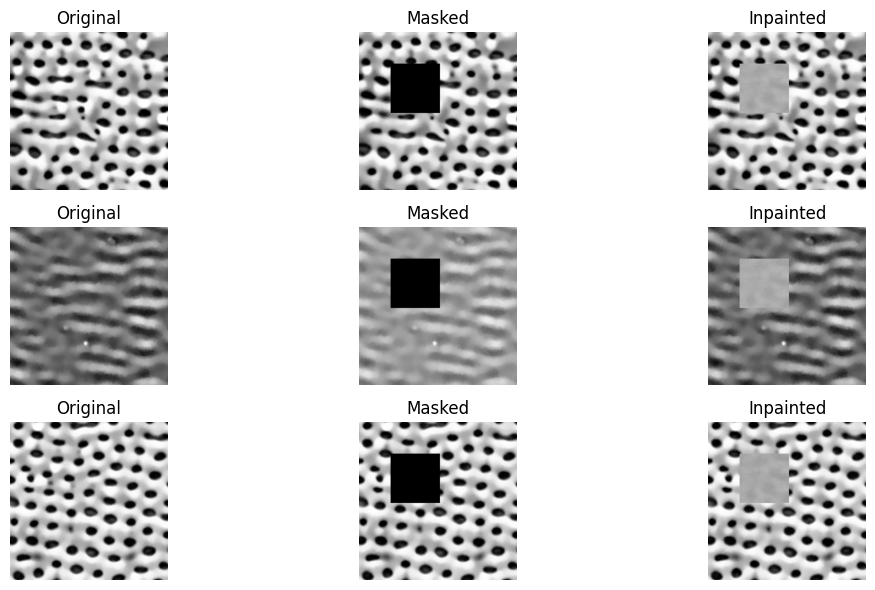

Epoch: 2, Test set ELBO: -150554.109375, time elapse for current epoch: 7.058984279632568
Average SSIM: 0.9369199187346909, Average PSNR: 21.991918581114955


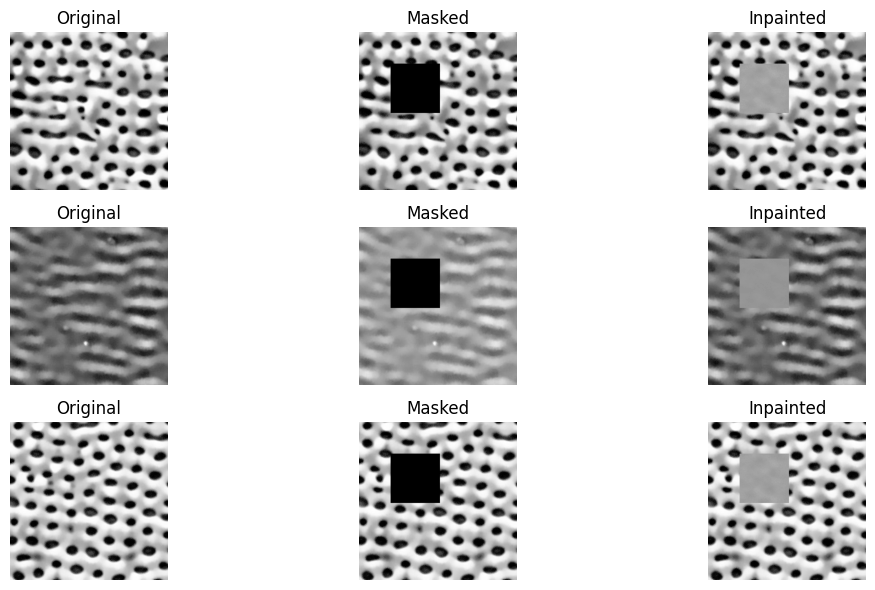

Epoch: 3, Test set ELBO: -150164.65625, time elapse for current epoch: 7.09848165512085
Average SSIM: 0.9371224094494576, Average PSNR: 22.07682574558117


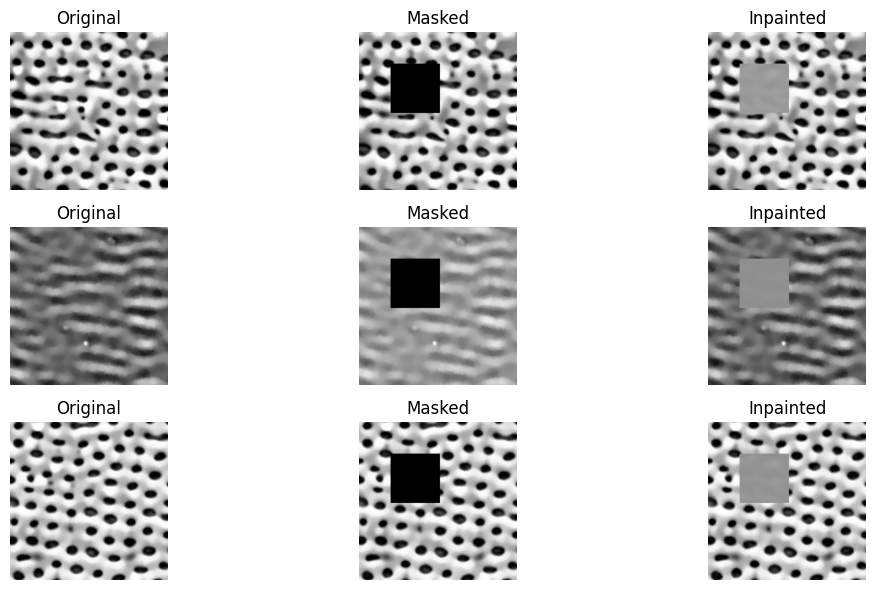

Epoch: 4, Test set ELBO: -149973.734375, time elapse for current epoch: 7.151222229003906
Average SSIM: 0.9375223709661844, Average PSNR: 22.25503619349492


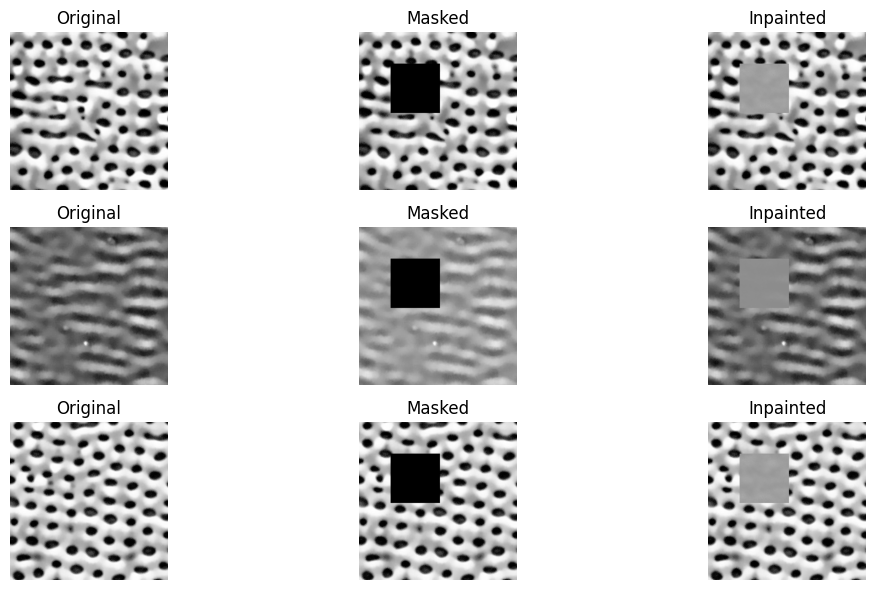

Epoch: 5, Test set ELBO: -148008.984375, time elapse for current epoch: 7.165490388870239
Average SSIM: 0.9372360754072798, Average PSNR: 22.241809813853333


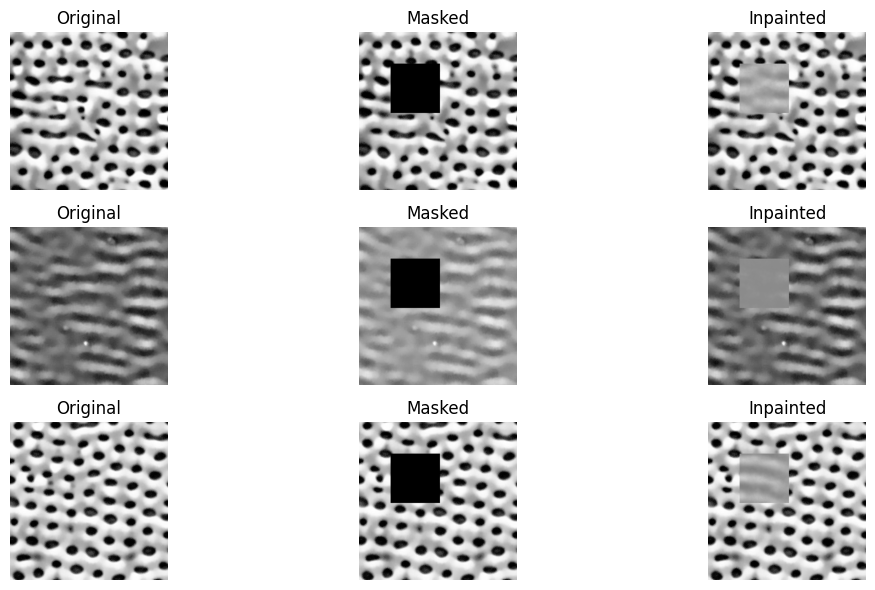

Epoch: 6, Test set ELBO: -143822.203125, time elapse for current epoch: 7.1587114334106445
Average SSIM: 0.9400001587563139, Average PSNR: 22.522890623601942


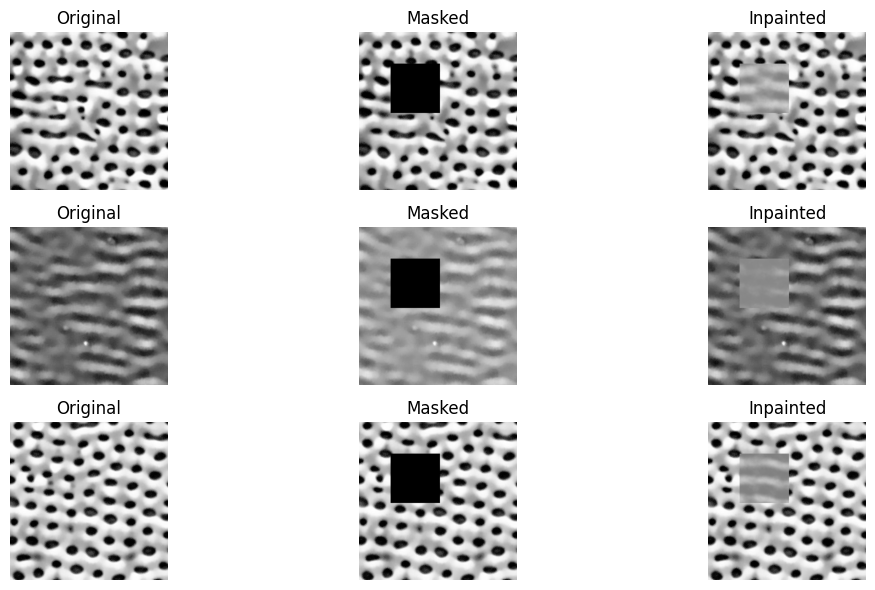

Epoch: 7, Test set ELBO: -142338.9375, time elapse for current epoch: 7.165081024169922
Average SSIM: 0.9414864094789709, Average PSNR: 22.741528182721094


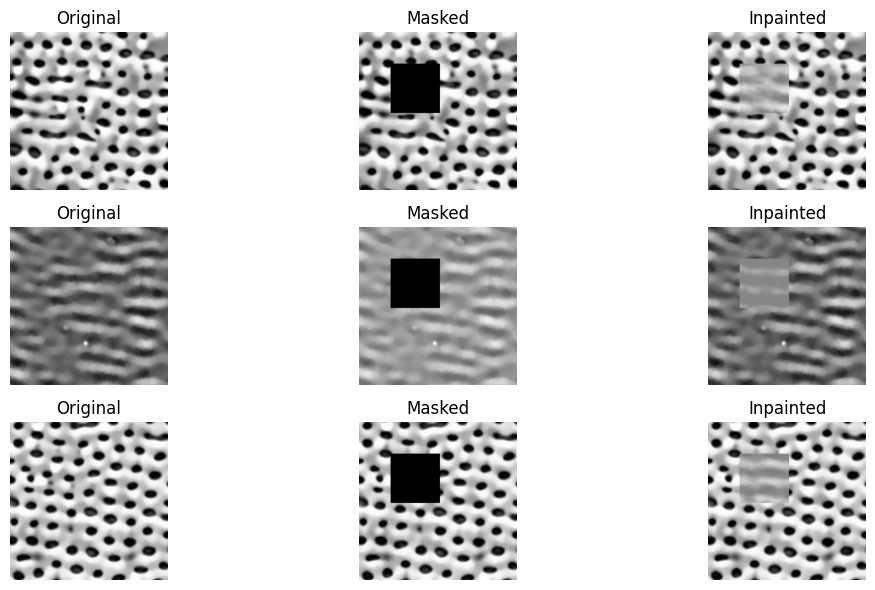

Epoch: 8, Test set ELBO: -140861.359375, time elapse for current epoch: 7.171869277954102
Average SSIM: 0.9369620058856443, Average PSNR: 22.44291755599267


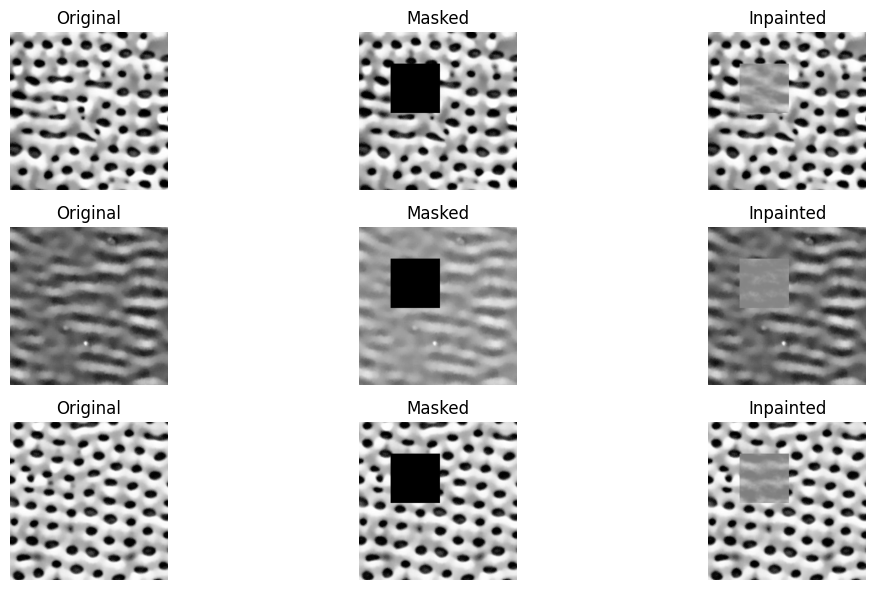

Epoch: 9, Test set ELBO: -138828.671875, time elapse for current epoch: 7.137271165847778
Average SSIM: 0.9401358467320172, Average PSNR: 22.9672901956997


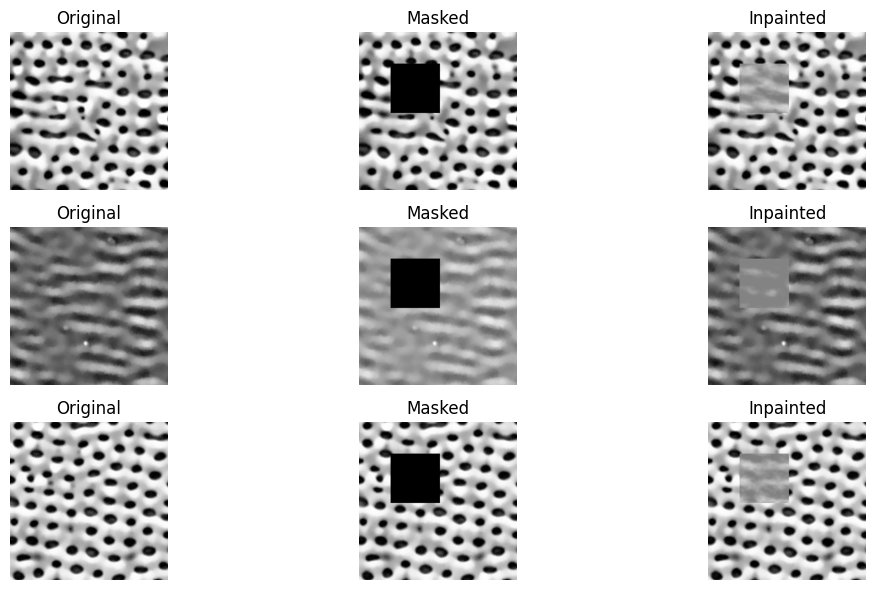

Epoch: 10, Test set ELBO: -139132.71875, time elapse for current epoch: 7.124100208282471
Average SSIM: 0.9401850032182048, Average PSNR: 23.180615656501942


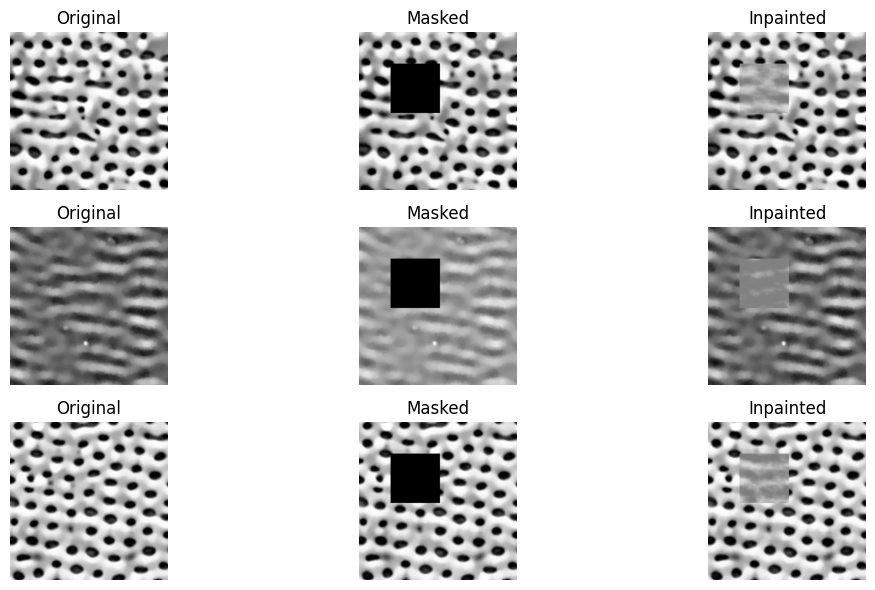

Epoch: 11, Test set ELBO: -137486.96875, time elapse for current epoch: 7.14061164855957
Average SSIM: 0.9391111344350657, Average PSNR: 23.36037653231035


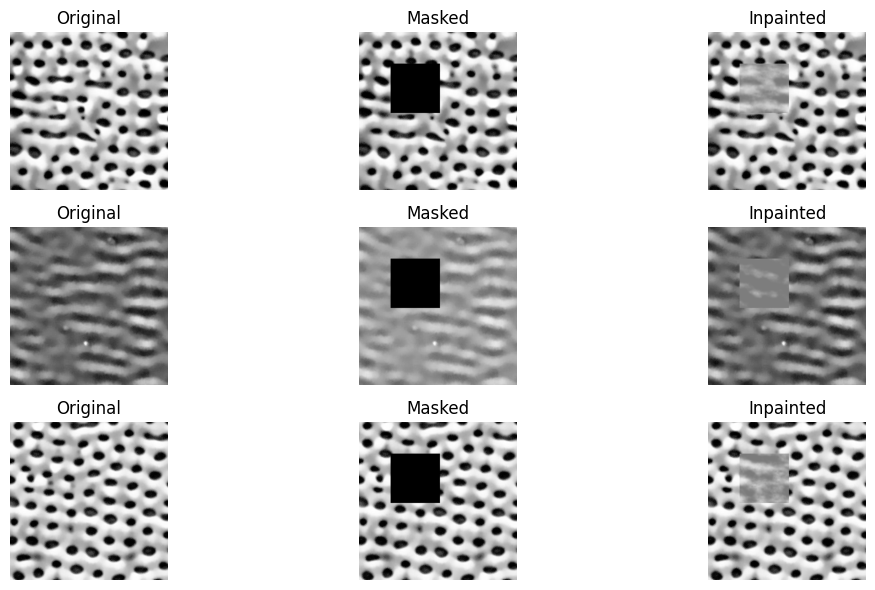

Epoch: 12, Test set ELBO: -137595.125, time elapse for current epoch: 7.22312068939209
Average SSIM: 0.9384905525670947, Average PSNR: 23.50913426671553


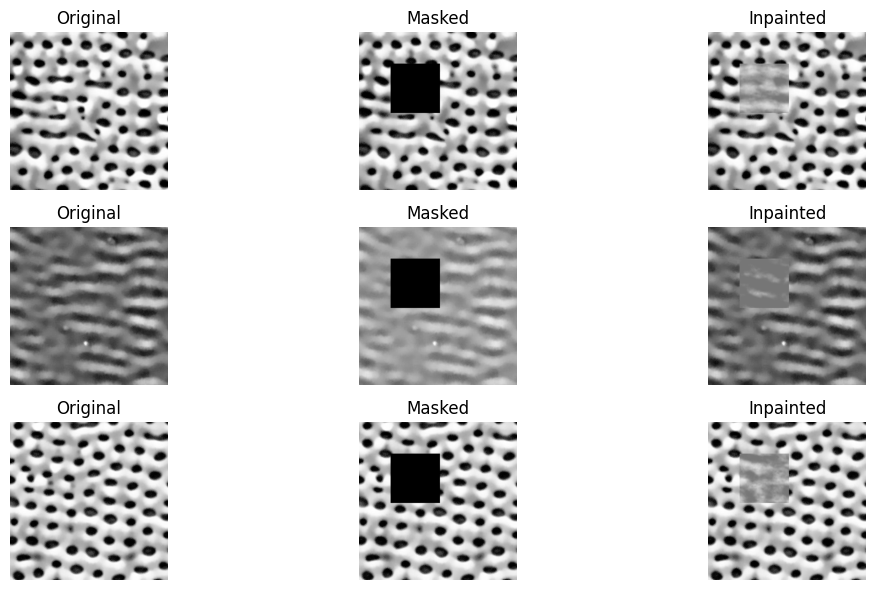

Epoch: 13, Test set ELBO: -138061.5625, time elapse for current epoch: 7.296868324279785
Average SSIM: 0.9373524820042531, Average PSNR: 23.528002850461565


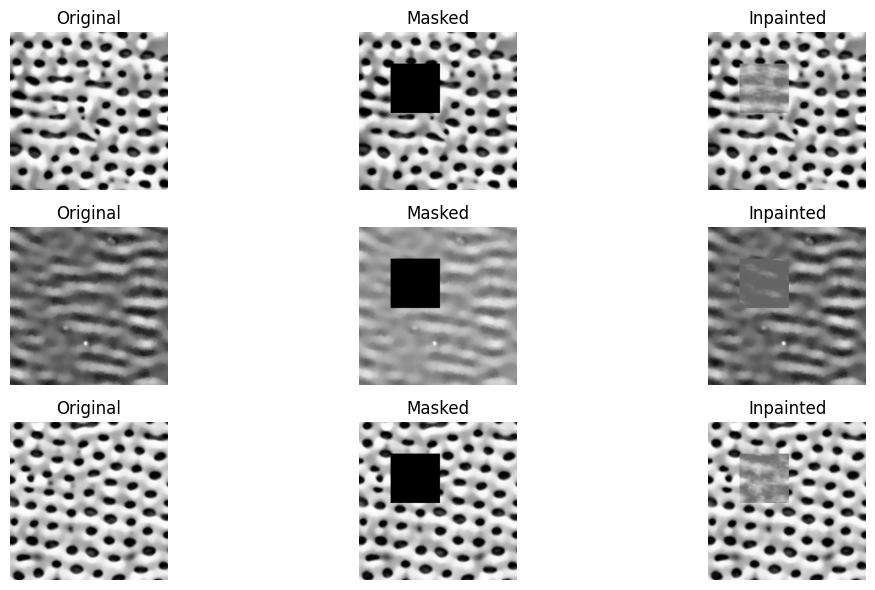

Epoch: 14, Test set ELBO: -137733.28125, time elapse for current epoch: 7.325758934020996
Average SSIM: 0.9311616398962531, Average PSNR: 22.79263403170759


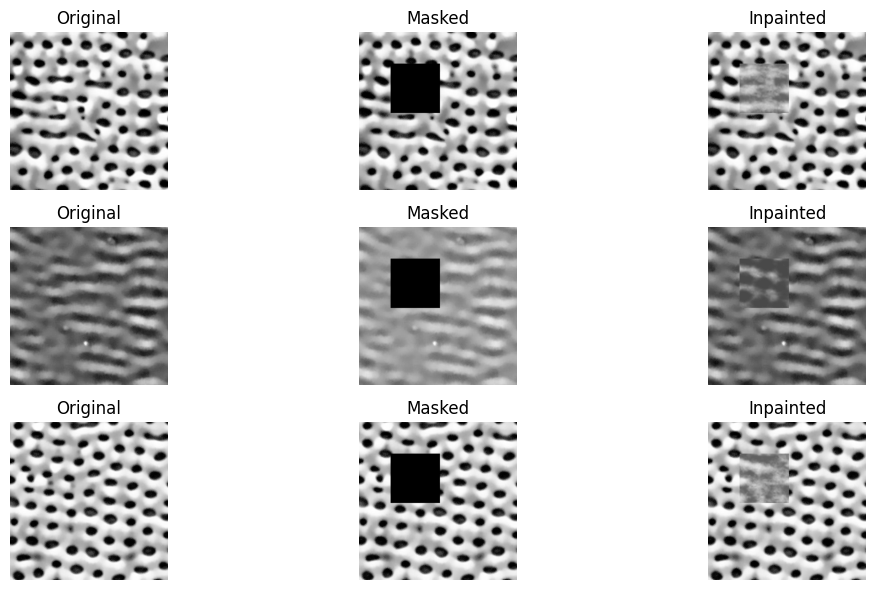

Early stopping triggered at epoch 14 (patience=3)


In [20]:
# Training Loop

for epoch in range(1, epochs + 1):
  # Train Step
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  # Loss calculation
  loss = tf.keras.metrics.Mean()
  for test_x in eval_dataset:
   loss(compute_loss(model, test_x))
  elbo = -loss.result()

  # Early stopping check
  if elbo > best_loss:
      best_loss = elbo  # Update best loss
      wait = 0  # Reset wait counter
  else:
      wait += 1  # Increment wait counter

  # We print loss and image of current iteration
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
       .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, eval_sample)

  #Check if need to stop
  if wait >= patience:
    print(f"Early stopping triggered at epoch {epoch} (patience={patience})")
    break

In [21]:
# Finally, we calculate the metrics for the test set
calculate_similarity_metrics(model, test_sample)

Average SSIM: 0.9360769639622983, Average PSNR: 22.19421104799833


In [ ]:
# End of notebook!